In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time

import matplotlib.pyplot as plt

import scipy
from scipy import linalg

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from WrapScalableSVM import *
from Utils_SSVM import *
from utilsData import *
from modelEvaluation import *
from utilsPlot import *

import joblib
from scipy.stats import mannwhitneyu, ks_2samp, ttest_ind

# Tests for the xAI-2024 conference paper
# Load datasets

In [3]:
datapath = "simulationVictorTopological/"
train = "train.csv"
test = "test.csv"
cal = "calib.csv"

In [4]:
dbtrain = pd.read_csv(datapath+train)
dbtest = pd.read_csv(datapath+test)
dbcal = pd.read_csv(datapath+cal)
dbtrain

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output
0,0.299695,0.270826,0.839194,2.749909,2.75330,0.026078,0.037425,1
1,0.495451,0.340952,0.231894,2.770800,2.78160,0.021350,0.029500,1
2,0.219487,0.779657,0.194163,2.758996,2.75825,0.028121,0.034400,1
3,0.224938,0.265979,0.897852,2.751966,2.75460,0.020068,0.025050,0
4,0.406129,0.848177,0.286591,2.784231,2.78370,0.027460,0.029750,1
...,...,...,...,...,...,...,...,...
3995,0.436775,0.320333,0.186794,2.801548,2.81070,0.023131,0.036600,1
3996,0.496358,0.969954,0.928142,2.801348,2.80265,0.023239,0.026600,1
3997,0.268565,0.941123,0.071780,2.779971,2.77950,0.019686,0.024525,1
3998,0.417594,0.150718,0.077583,2.805012,2.81400,0.022587,0.044000,1


In [5]:
sum(dbtrain.output) + sum(dbcal.output) + sum(dbtest.output)

6690

Separate features and labels, and convert label 0 with 1 and 1 with -1

In [6]:
Xtr = dbtrain[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Ytr = dbtrain[['output']].values
Ytr[Ytr==1] = -1
Ytr[Ytr==0] = 1

Xts = dbtest[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Yts = dbtest[['output']].values
Yts[Yts==1] = -1
Yts[Yts==0] = 1

Xcal = dbcal[['SafetyMargin', 'Eta', 'Tau','meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']].values
Ycal = dbcal[['output']].values
Ycal[Ycal==1] = -1
Ycal[Ycal==0] = 1

# Exploratory analisis

In [7]:
correlation_matrix = dbtrain.corr()
print(correlation_matrix)

dbtrain['outputTrans'] = dbtrain['output'].apply(lambda x: 1 if x == 1 else 0)
dbtrain

               SafetyMargin       Eta       Tau  meanEntropy  medianEntropy  \
SafetyMargin       1.000000 -0.006068  0.019482     0.917576       0.914547   
Eta               -0.006068  1.000000 -0.000401     0.045082       0.042241   
Tau                0.019482 -0.000401  1.000000    -0.118042      -0.119090   
meanEntropy        0.917576  0.045082 -0.118042     1.000000       0.997136   
medianEntropy      0.914547  0.042241 -0.119090     0.997136       1.000000   
stdsEntropy       -0.283973 -0.051064 -0.046355    -0.379528      -0.368941   
iqrsEntropy       -0.081905 -0.048141 -0.032447    -0.173620      -0.172358   
output             0.572219 -0.013574  0.040603     0.402749       0.402820   

               stdsEntropy  iqrsEntropy    output  
SafetyMargin     -0.283973    -0.081905  0.572219  
Eta              -0.051064    -0.048141 -0.013574  
Tau              -0.046355    -0.032447  0.040603  
meanEntropy      -0.379528    -0.173620  0.402749  
medianEntropy    -0.368941  

,SafetyMargin,Eta,Tau,meanEntropy,medianEntropy,stdsEntropy,iqrsEntropy,output,outputTrans
0,0.299695,0.270826,0.839194,2.749909,2.75330,0.026078,0.037425,1,1
1,0.495451,0.340952,0.231894,2.770800,2.78160,0.021350,0.029500,1,1
2,0.219487,0.779657,0.194163,2.758996,2.75825,0.028121,0.034400,1,1
3,0.224938,0.265979,0.897852,2.751966,2.75460,0.020068,0.025050,0,0
4,0.406129,0.848177,0.286591,2.784231,2.78370,0.027460,0.029750,1,1
...,...,...,...,...,...,...,...,...,...
3995,0.436775,0.320333,0.186794,2.801548,2.81070,0.023131,0.036600,1,1
3996,0.496358,0.969954,0.928142,2.801348,2.80265,0.023239,0.026600,1,1
3997,0.268565,0.941123,0.071780,2.779971,2.77950,0.019686,0.024525,1,1
3998,0.417594,0.150718,0.077583,2.805012,2.81400,0.022587,0.044000,1,1


## Dispersion plots

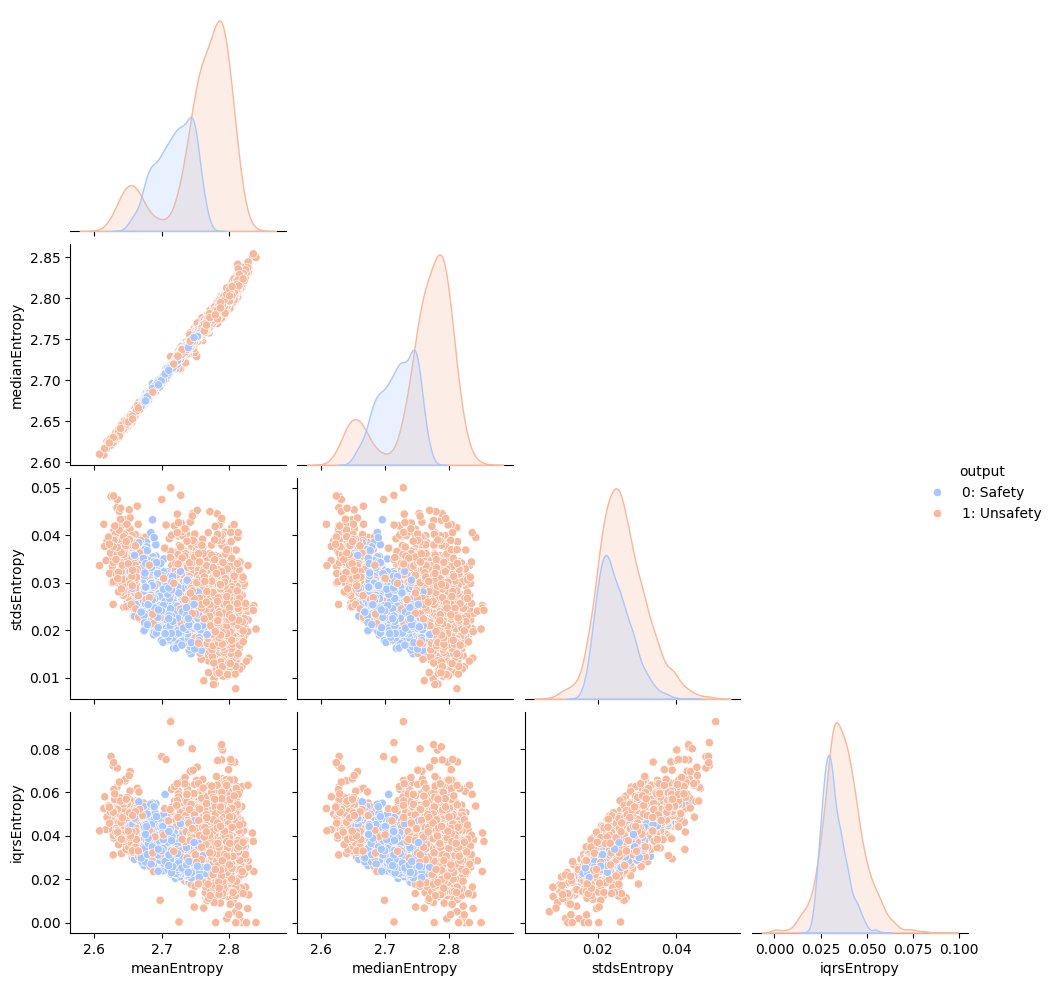

In [9]:
pairplot = sns.pairplot(dbtrain, vars=['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy'], hue='output', palette='coolwarm',corner=True)
new_labels = ['0: Safety', '1: Unsafety']  # Nombres personalizados
for t, label in zip(pairplot._legend.texts, new_labels):
    t.set_text(label)
plt.show()

## Boxplots

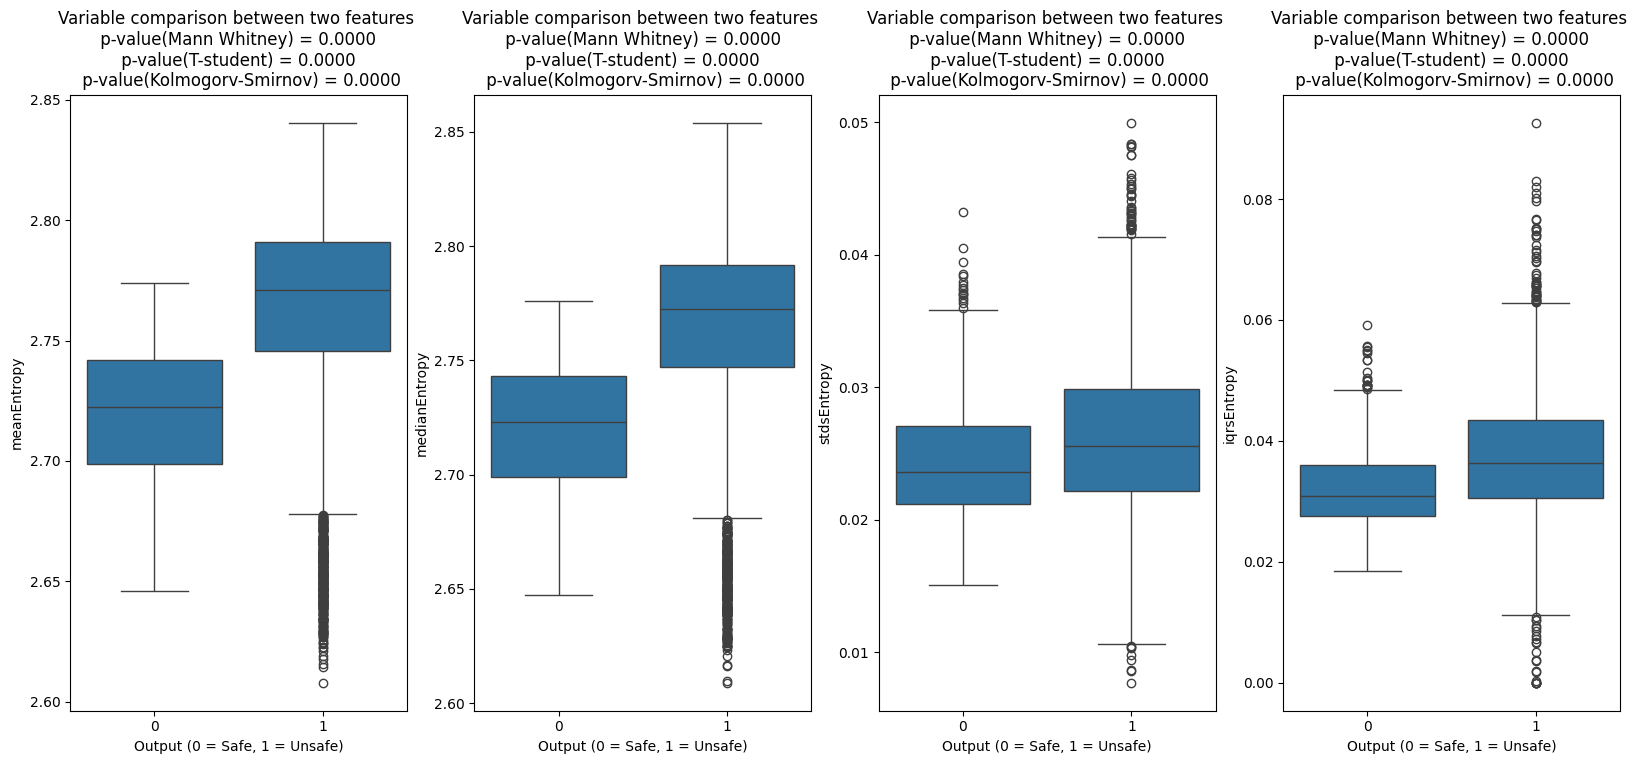

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 8))
axes = axes.flatten()
for num,i in enumerate(['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy']):
    Cvalues = dbtrain[dbtrain["output"] == 1][i].values
    NCvalues = dbtrain[dbtrain["output"] == 0][i].values
    stat1, p_value1 = mannwhitneyu(Cvalues, NCvalues, alternative="two-sided")
    stat2, p_value2 = ttest_ind(Cvalues, NCvalues,equal_var=True)
    stat3, p_value3 = ks_2samp(Cvalues, NCvalues)
    plt.sca(axes[num])
    sns.boxplot(x='output', y=i, data=dbtrain)
    plt.title(f'Variable comparison between two features \n p-value(Mann Whitney) = {p_value1:.4f} \n p-value(T-student) = {p_value2:.4f} \n p-value(Kolmogorv-Smirnov) = {p_value3:.4f}')
    plt.xlabel("Output (0 = Safe, 1 = Unsafe)")
    plt.ylabel(i)

plt.show()

# SVM parameters setting

In [8]:
# Parameters settings
kernel = "gaussian" #with gaussian work, with polynomial no.
param = 0.2 # play with this to improve model evaluation, explaination on chatgpt
tau = np.array([[0.5]])
eta = 0.3

# Scaling setting

In [9]:
epsilon = 0.1

## 1) Classic SVM

In [10]:
start_time = time.time()

model = ScalableSVMClassifier(eta, kernel, param, tau)

model = model.fit(Xtr[:,-4:],Ytr) #[:,-4:] solo caract topol
joblib.dump(model, datapath+"classicSVM_safeEff.sav")
end_time = time.time()

elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 59.51445770263672 seconds


In [11]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, epsilon,'classic')
model.get_params()

{'alpha': array([ 4.99882127e-01, -9.15858789e-05,  4.99863490e-01, ...,
        -9.69180028e-05, -1.37421751e-04,  4.99954837e-01]),
 'b': array([-4.49645653]),
 'b_eps': 0,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.2,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

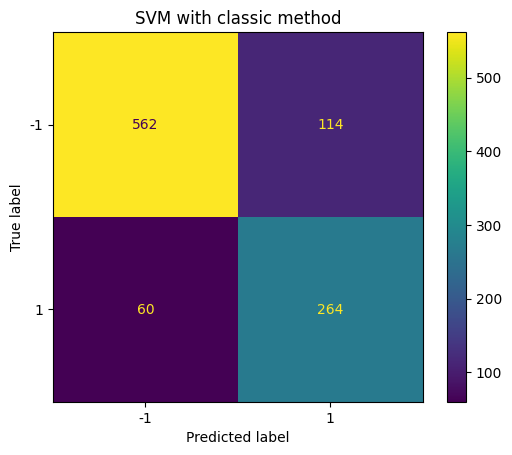

ACC = 0.826, F1 = 0.7521367521367521, PPV = 0.6984126984126984, NPV = 0.9035369774919614, TPR = 0.8148148148148148, TNR = 0.8313609467455622, FPR = 0.16863905325443787, FNR = 0.18518518518518517

TP = 264, FP = 114, TN = 562, FN = 60


In [12]:
metricsClassic = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")


In [13]:
joblib.dump(model,datapath+"Classic_SVM_safe.sav")

['simulationVictorTopological/Classic_SVM_safe.sav']

## 2) Probabilistic Safety Region

In [14]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, epsilon,'ps')
model.get_params()

{'alpha': array([ 4.99882127e-01, -9.15858789e-05,  4.99863490e-01, ...,
        -9.69180028e-05, -1.37421751e-04,  4.99954837e-01]),
 'b': array([-4.49645653]),
 'b_eps': 0.3176271371950259,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.2,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

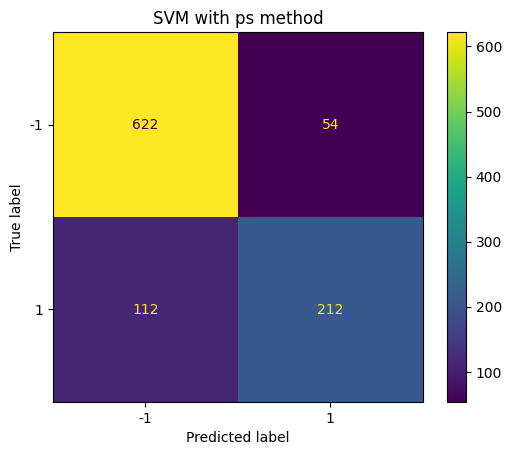

ACC = 0.834, F1 = 0.7186440677966102, PPV = 0.7969924812030075, NPV = 0.8474114441416893, TPR = 0.654320987654321, TNR = 0.9201183431952663, FPR = 0.07988165680473373, FNR = 0.345679012345679

TP = 212, FP = 54, TN = 622, FN = 112


In [15]:
metricsPSR = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")

In [16]:
joblib.dump(model,datapath+"PS_SVM_safe.sav")

['simulationVictorTopological/PS_SVM_safe.sav']

In [17]:
# save to file
y_ps_tr = model.predict(Xtr[:,-4:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,-4:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,-4:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,-4:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,-4:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,-4:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_ps.csv", index = False)
calib.to_csv(datapath+"calib_ps.csv", index = False)
test.to_csv(datapath+"test_ps.csv", index = False)

# 3) Conformal Safety Regions


In [18]:
model = model.FPcontrol(Xcal[:,-4:], Ycal, 0.1,'cp')
model.get_params()

{'alpha': array([ 4.99882127e-01, -9.15858789e-05,  4.99863490e-01, ...,
        -9.69180028e-05, -1.37421751e-04,  4.99954837e-01]),
 'b': array([-4.49645653]),
 'b_eps': 0.20106051501801608,
 'eta': 0.3,
 'kernel': 'gaussian',
 'param': 0.2,
 'tau': array([[0.5]]),
 'solver': 'osqp'}

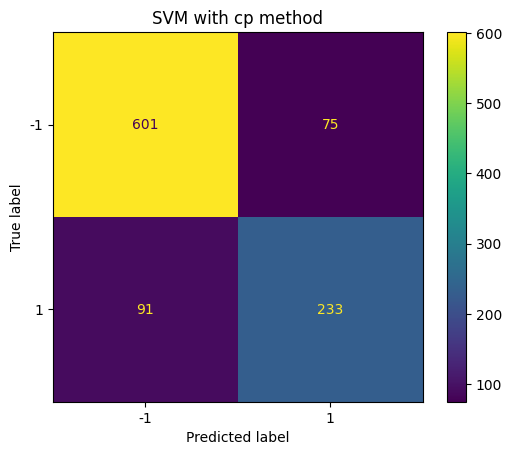

ACC = 0.834, F1 = 0.7373417721518988, PPV = 0.7564935064935064, NPV = 0.8684971098265896, TPR = 0.7191358024691358, TNR = 0.8890532544378699, FPR = 0.11094674556213018, FNR = 0.2808641975308642

TP = 233, FP = 75, TN = 601, FN = 91


In [19]:
metricsCSR = EvaluateModel(model, Xts[:,-4:], Yts, f"SVM with {model.method} method")

In [20]:
joblib.dump(model,datapath+"CP_SVM_safe.sav")

['simulationVictorTopological/CP_SVM_safe.sav']

In [21]:
# save to file
y_ps_tr = model.predict(Xtr[:,-4:]).reshape((len(Xtr),1))
y_ps_cal = model.predict(Xcal[:,-4:]).reshape((len(Xcal),1))
y_ps_ts = model.predict(Xts[:,-4:]).reshape((len(Xts),1))

train = pd.DataFrame(np.hstack((Xtr[:,-4:],Ytr,y_ps_tr)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
calib = pd.DataFrame(np.hstack((Xcal[:,-4:],Ycal,y_ps_cal)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
test = pd.DataFrame(np.hstack((Xts[:,-4:],Yts,y_ps_ts)), columns = ['meanEntropy', 'medianEntropy', 'stdsEntropy', 'iqrsEntropy',"y_true","y_conformal"])
train.to_csv(datapath+"train_cp.csv", index = False)
calib.to_csv(datapath+"calib_cp.csv", index = False)
test.to_csv(datapath+"test_cp.csv", index = False)